<a href="https://colab.research.google.com/github/hawkeyedatatsai/Stroke-Prediction/blob/main/Stroke_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Stroke Prediction



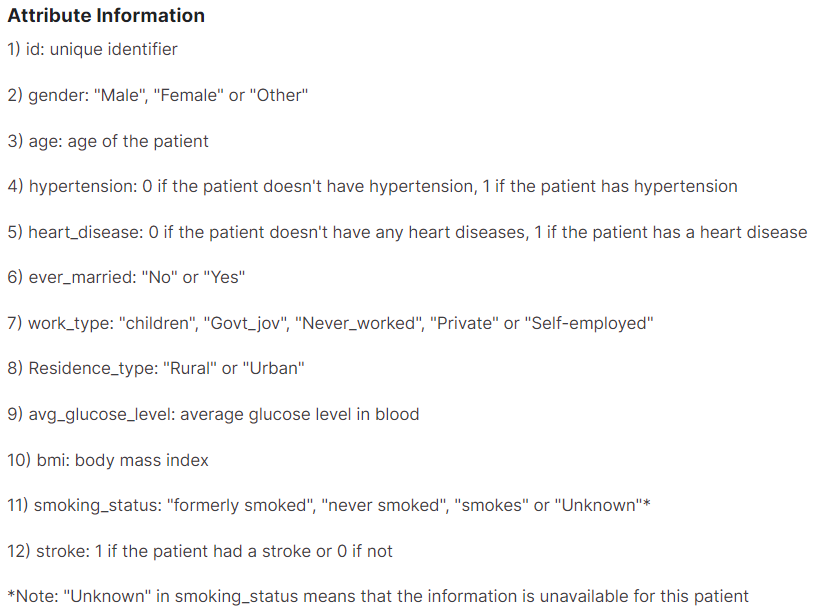

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn import set_config
set_config(display='diagram')
from sklearn.metrics import classification_report, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, roc_auc_score 
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from google.colab import drive

#Data Cleaning
The following topics will be addressed
- Deleted unnecessary columns.
- Deleted duplicate rows.
- Identified and addressed missing values.
-Identified and corrected inconsistencies in data for categorical values (i.e. Cat, cat, cats).
- Produced univariate visuals for the target and all features.
- Identified outliers.
- Clearly commented all of your cleaning steps and described any decisions you made.

In [2]:
filename = "/content/healthcare-dataset-stroke-data.csv"
df = pd.read_csv(filename)
print(df.info())
print(df.shape)
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB
None
(5110, 12)


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
#decide to drop id since it doesnt help us make prediction
df = df.drop(["id"], axis=1)

In [4]:
df.duplicated().sum()
#suggest no duplicate

0

In [5]:
df.isna().sum()/len(df)*100
#slight missing values on BMI, can fill it back with simpleimputer later

gender               0.000000
age                  0.000000
hypertension         0.000000
heart_disease        0.000000
ever_married         0.000000
work_type            0.000000
Residence_type       0.000000
avg_glucose_level    0.000000
bmi                  3.933464
smoking_status       0.000000
stroke               0.000000
dtype: float64

In [6]:
#check for inconsistent values in categorical columns
for col in list(df.select_dtypes(include='object')):
  print(col)
  print(df[col].value_counts())
  print()
#will drop "other" on gender since its very minor
#Plan to keep "Unknown" in smoking_status because its a huge portion of the col

gender
Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

ever_married
Yes    3353
No     1757
Name: ever_married, dtype: int64

work_type
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

Residence_type
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

smoking_status
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64



In [7]:
df[df["gender"] == 'Other']
df.drop(df.loc[df["gender"] == 'Other'].index, inplace=True)
print(df.describe())
df.describe(include="object")

               age  hypertension  heart_disease  avg_glucose_level  \
count  5109.000000   5109.000000    5109.000000        5109.000000   
mean     43.229986      0.097475       0.054022         106.140399   
std      22.613575      0.296633       0.226084          45.285004   
min       0.080000      0.000000       0.000000          55.120000   
25%      25.000000      0.000000       0.000000          77.240000   
50%      45.000000      0.000000       0.000000          91.880000   
75%      61.000000      0.000000       0.000000         114.090000   
max      82.000000      1.000000       1.000000         271.740000   

              bmi       stroke  
count  4908.00000  5109.000000  
mean     28.89456     0.048738  
std       7.85432     0.215340  
min      10.30000     0.000000  
25%      23.50000     0.000000  
50%      28.10000     0.000000  
75%      33.10000     0.000000  
max      97.60000     1.000000  


,gender,ever_married,work_type,Residence_type,smoking_status
count,5109,5109,5109,5109,5109
unique,2,2,5,2,4
top,Female,Yes,Private,Urban,never smoked
freq,2994,3353,2924,2596,1892


- [From this link](https://my.clevelandclinic.org/health/diagnostics/12363-blood-glucose-test) , glucose level between 70-99 mg/dl is considered normal whilst 100-125 suggests prediabetes. If the blood glucose level is 126 mg/dl (7.0 mmol/L) or higher on more than one testing occasion, it usually means diabetes. Therefore, I do not plan to change anything on "avg_glucose_level".

- max bmi 97 is still in reasonable range when talking abt extreme obesity scenario.


In [8]:
#Feature ranking with recursive feature elimination
#https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html
class sklearn.feature_selection.RFE(estimator, *, n_features_to_select=None, 
                                    step=1, verbose=0, importance_getter='auto')

SyntaxError: ignored

#Exploratory Data

##On each and individual columns

In [ ]:
#Strategy
#stroke, hypertension and heart_disease are binary variable -> pie chart
#categorial data -> barplot
#numercial data -> histogram

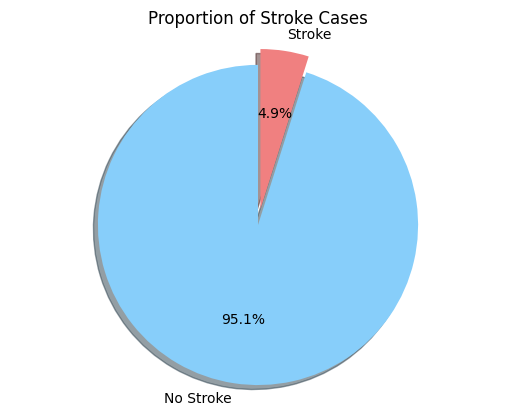

In [20]:
#TARGET!!
stroke_count = df['stroke'].value_counts()
labels = ['No Stroke', 'Stroke']
colors = ['lightskyblue', 'lightcoral']
explode = (0, 0.1)
plt.pie(stroke_count, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=90)
plt.axis('equal')
plt.title('Proportion of Stroke Cases')
plt.show()

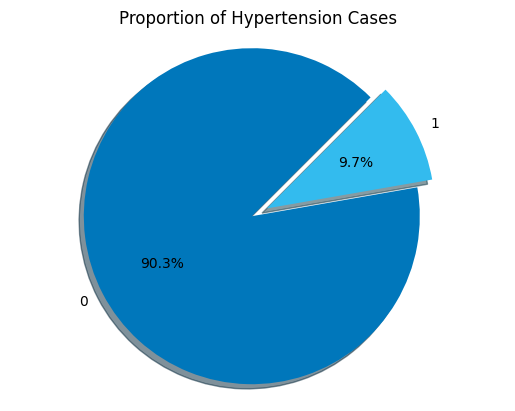

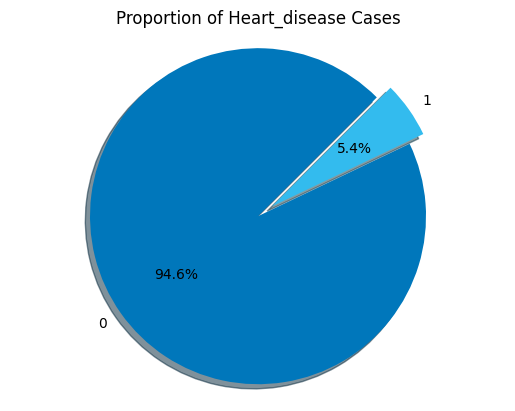

In [29]:
columns = ['hypertension', 'heart_disease']

#create a pie chart for these two columns
for column in columns:
    column_count = df[column].value_counts()
    labels = [str(x) for x in column_count.index]
    colors = ['#0077BB', '#33BBEE']
    explode = (0, 0.1)
    plt.pie(column_count, explode=explode, labels=labels, colors=colors,
            autopct='%1.1f%%', shadow=True, startangle=45)
    plt.axis('equal')
    plt.title(f"Proportion of {column.capitalize()} Cases")
    plt.show()

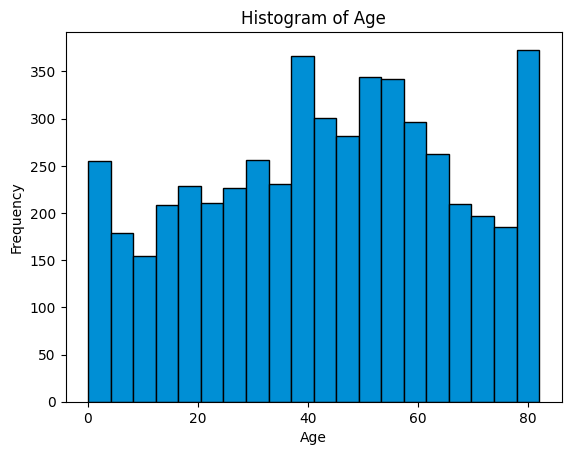

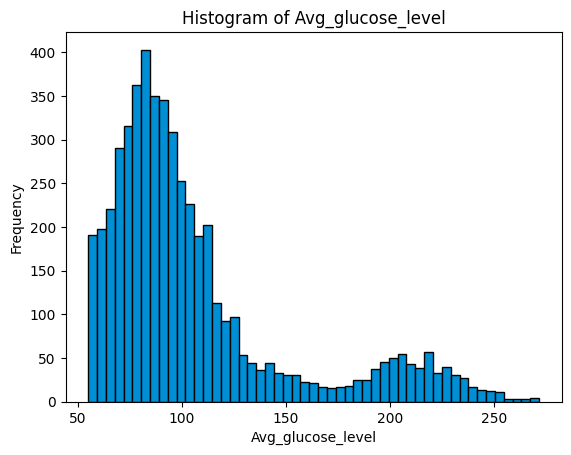

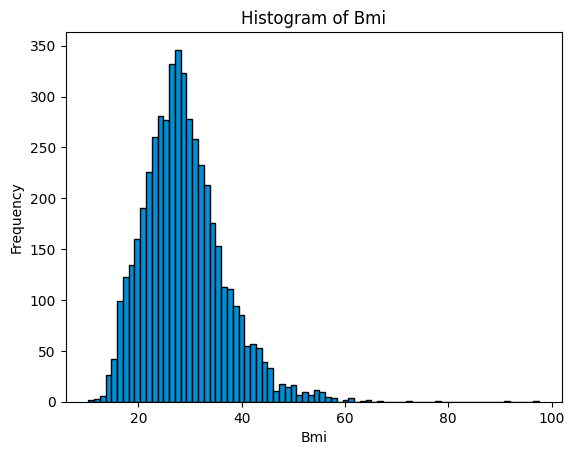

In [34]:
#create histograms for each numerical column
for col in ['age', 'avg_glucose_level', 'bmi']:
    plt.hist(df[col], bins="auto", color='#008fd5', edgecolor="black")
    plt.xlabel(col.capitalize())
    plt.ylabel('Frequency')
    plt.title(f'Histogram of {col.capitalize()}')
    plt.show()

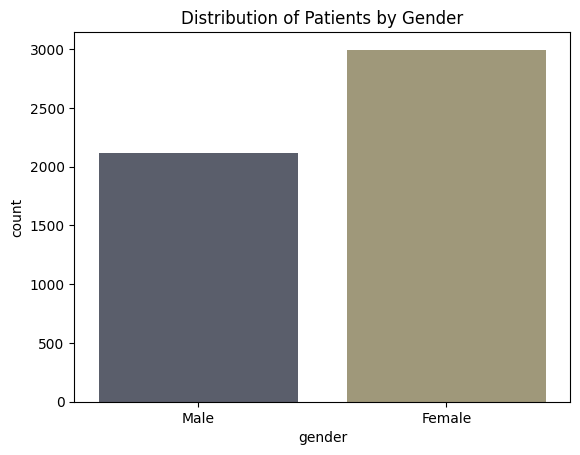

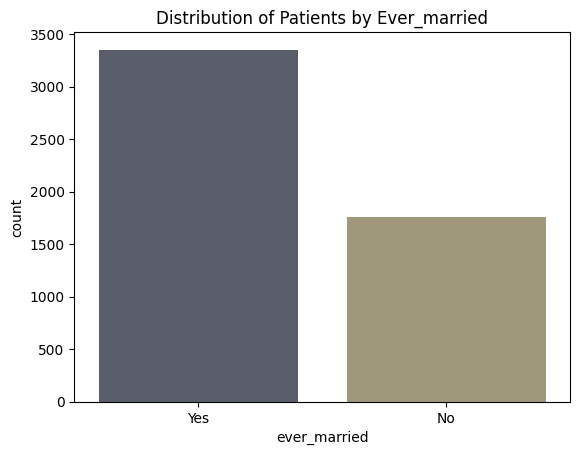

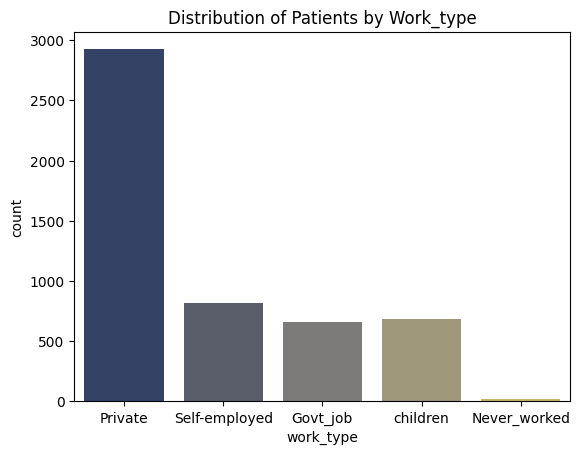

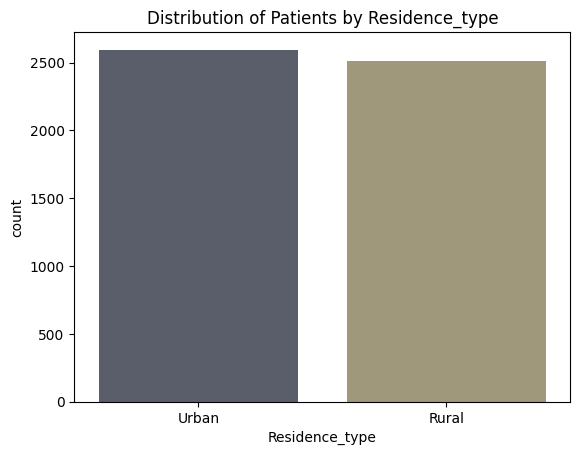

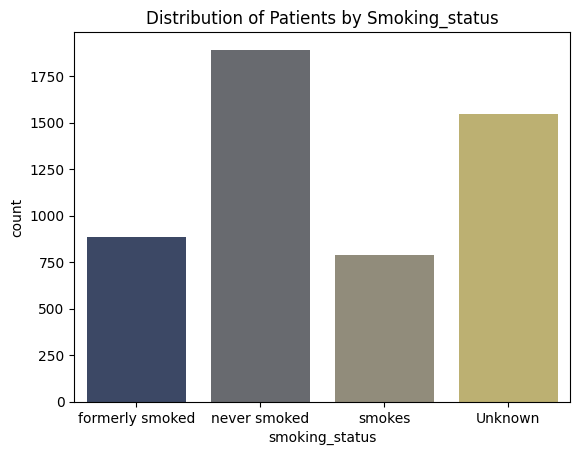

In [32]:
##present every categorial data with countplots
for col in df.select_dtypes(include='object').columns:
    sns.countplot(x=col, data=df, palette='cividis')
    plt.title(f'Distribution of Patients by {col.capitalize()}')
    plt.show()

##Identifying correlations between target and  features using a correlation heatmap

<ipython-input-35-03f7afabb904>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


<Axes: >

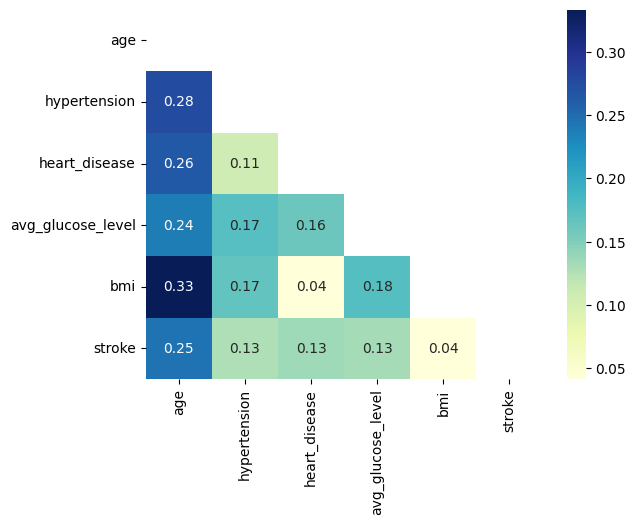

In [35]:
# Correlation Heatmap
corr = df.corr()
mask = np.triu(np.ones_like(corr))
sns.heatmap(corr, cmap = 'YlGnBu', annot = True, fmt=".2f", mask = mask)

##Creating multivariate exploratory visualizations to further understand data

Text(0, 0.5, 'BMI')

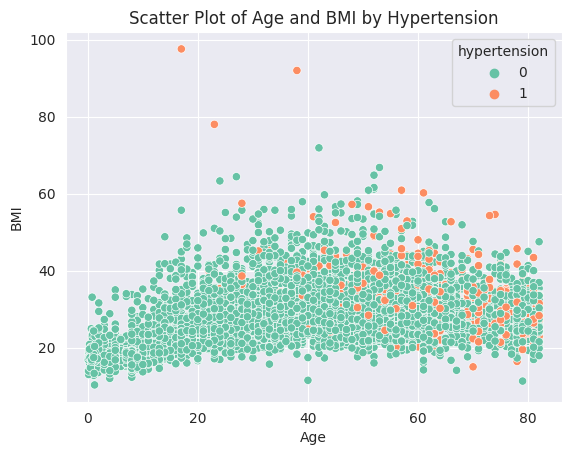

In [51]:
sns.set_style('darkgrid')
sns.scatterplot(y ='bmi', x = 'age', data = df, hue = 'hypertension', palette='Set2')
plt.title('Scatter Plot of Age and BMI by Hypertension')
plt.xlabel('Age')
plt.ylabel('BMI')

Text(33.51454077449846, 0.5, 'BMI')

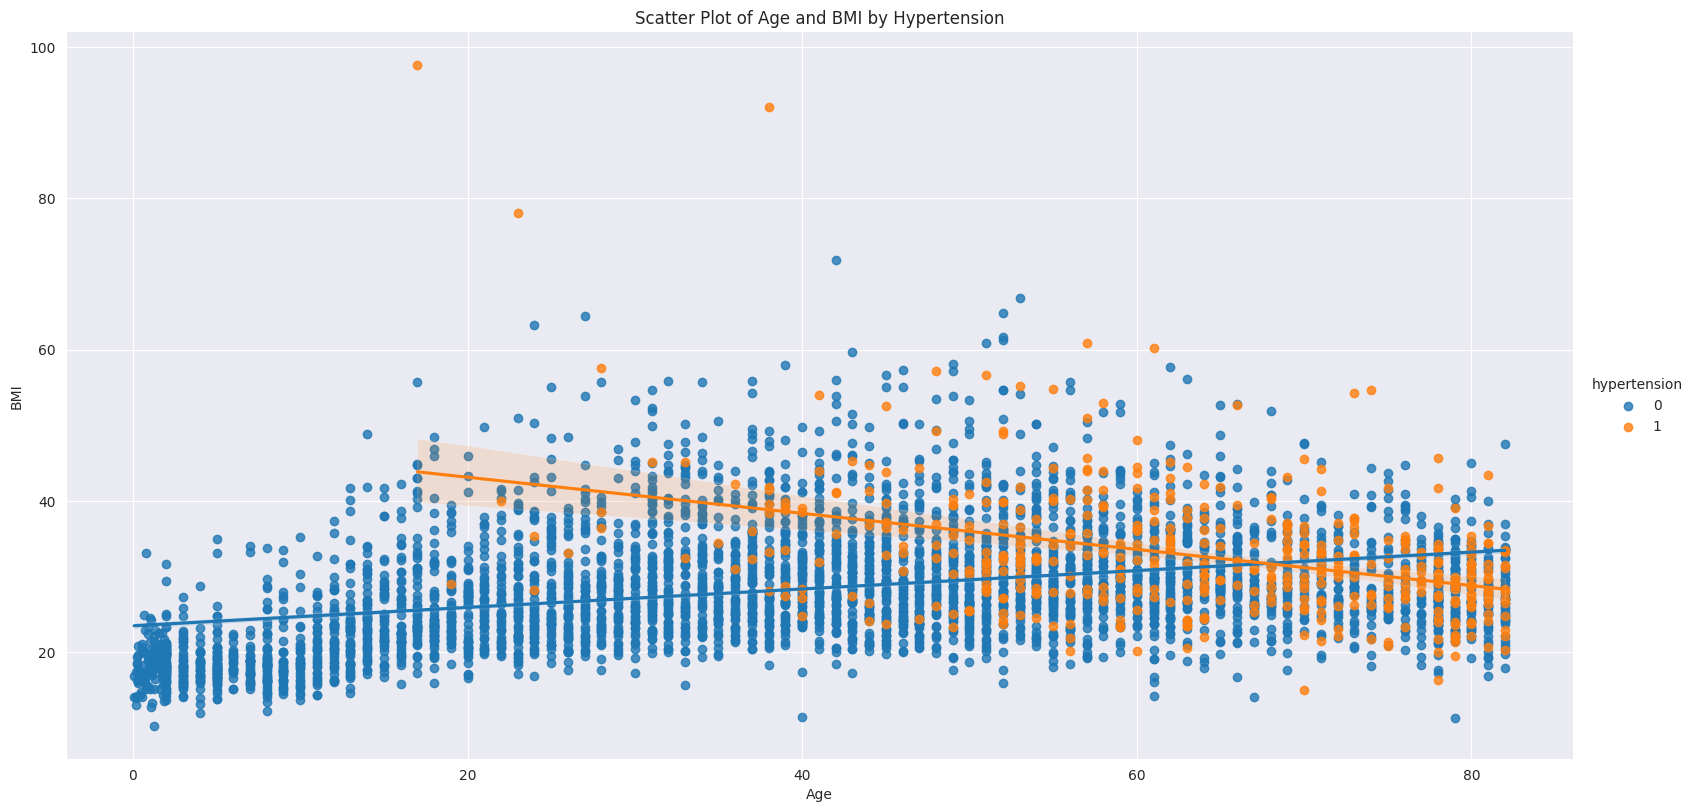

In [56]:
sns.set_style('darkgrid')
sns.lmplot(x='age', y='bmi', hue='hypertension', data=df, height=8
           , aspect=2)
plt.title('Scatter Plot of Age and BMI by Hypertension')
plt.xlabel('Age')
plt.ylabel('BMI')

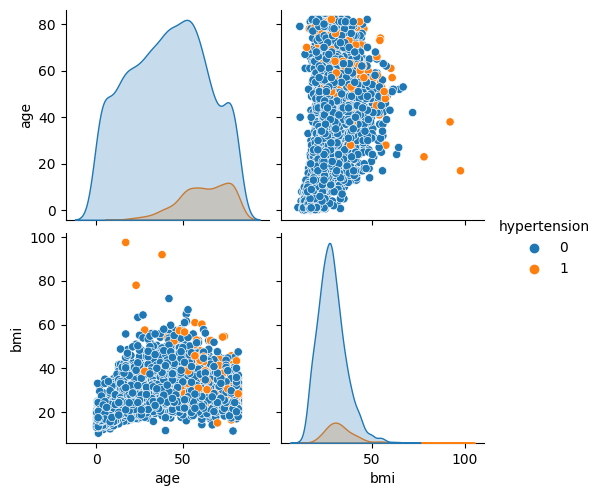

In [40]:
#columns of interest
cols = ['age', 'bmi', 'hypertension']

#Create a scatter plot matrix
sns.pairplot(df[cols], hue='hypertension')

/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:1609: UserWarning: 

`shade_lowest` has been replaced by `thresh`; setting `thresh=0.05.
This will become an error in seaborn v0.13.0; please update your code.

  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/axisgrid.py:1609: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=x, y=y, **kwargs)
/usr/local/lib/python3.9/dist-packages/seaborn/distributions.py:1138: UserWarning: cmap parameter ignored when using hue mapping.
  warnings.warn(msg, UserWarning)


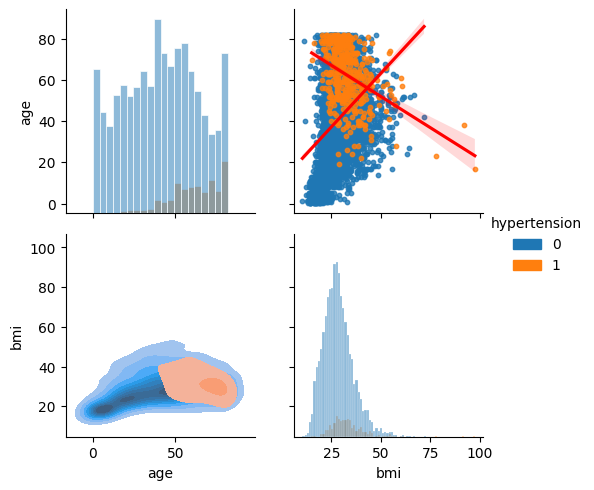

In [42]:
cols = ['age', 'bmi', 'hypertension']

# Create a scatter plot matrix with regression lines
g = sns.PairGrid(df[cols], hue='hypertension')
g.map_upper(sns.regplot, scatter_kws={'s': 10}, line_kws={'color': 'red'})
g.map_lower(sns.kdeplot, cmap='Blues_d', shade=True, shade_lowest=False)
g.map_diag(sns.histplot, kde=False, color='black', edgecolor='white')
g.add_legend()

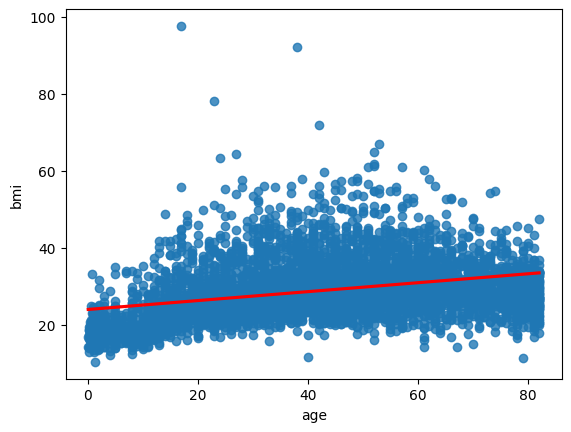

In [38]:
ax = sns.regplot(x ='age', y = 'bmi', data = df, line_kws = {'color':'red'})